In [1]:
import os
import random
import shutil

# Path to your full dataset
dataset_path = "D:/SEM 3/Deep Learning/Assignment 4/photos"
sampled_path = "D:/SEM 3/Deep Learning/Assignment 4/sampled_photos"

# List all image files
all_images = os.listdir(dataset_path)

# I have Define the sample size
sample_size = 10000  # Adjust this as needed (e.g., 5000 or 20000)

# Randomly sample images
sampled_images = random.sample(all_images, sample_size)

# Create a folder for sampled images
os.makedirs(sampled_path, exist_ok=True)

# Copy sampled images to the new folder
for img in sampled_images:
    shutil.copy(os.path.join(dataset_path, img), os.path.join(sampled_path, img))

print(f"Sampled {len(sampled_images)} images to {sampled_path}")

Sampled 10000 images to D:/SEM 3/Deep Learning/Assignment 4/sampled_photos


### Preprocessing of Images 

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm 

In [5]:
# Path to sampled images
sampled_path = "D:/SEM 3/Deep Learning/Assignment 4/sampled_photos"

In [7]:
img_size = (128, 128)  # Resize all images to 128x128
data = []  # To store processed images

In [9]:
# Load and preprocess images
for img_name in tqdm(os.listdir(sampled_path), desc="Processing Images"):
    img_path = os.path.join(sampled_path, img_name)
    try:
        # Load and resize image
        img = load_img(img_path, target_size=img_size)
        # Convert to numpy array
        img_array = img_to_array(img)
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        # Append to data list
        data.append(img_array)
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

Processing Images:  28%|██▊       | 5543/19476 [00:40<01:54, 121.25it/s]

Error processing DMCTwC3UT2w5QzHOQoqBPw.jpg: cannot identify image file <_io.BytesIO object at 0x000001533E843F60>


Processing Images:  95%|█████████▍| 18458/19476 [02:12<00:07, 137.39it/s]

Error processing ytJ4lihJrvyzMMRG-WwDNw.jpg: cannot identify image file <_io.BytesIO object at 0x0000015348B56F70>


Processing Images: 100%|██████████| 19476/19476 [02:19<00:00, 139.16it/s]


In [11]:
data = np.array(data)

In [13]:
print(f"Number of valid images processed: {data.shape[0]}")
print(f"Shape of each image: {data.shape[1:]}")  # Should be (128, 128, 3)

Number of valid images processed: 19474
Shape of each image: (128, 128, 3)


# Image Processing Summary

- **Number of Valid Images**: 19,474  
  which indicates the total number of images successfully processed.

- **Image Shape**: (128, 128, 3)  
  Each image is resized to 128x128 pixels with 3 color channels (RGB).

### Building the VAE Model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define dimensions
latent_dim = 64  # Size of latent space

# ----- Sampling Layer -----
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        # Return configuration for serialization
        config = super(Sampling, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

 **Latent Dimension**:
   - `latent_dim = 64`: The dimensionality of the latent space where compressed data representations are stored.
 **Sampling Layer**:
   - Here, I made a custom layer that performs reparameterization using `z_mean` and `z_log_var` to add stochasticity.

In [18]:
# ----- Encoder -----
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="Encoder")

**Encoder**:
   - Encoder maps input images to a latent representation (`z_mean`, `z_log_var`, `z`).
   - which helps me in a dense layer for the latent space.

In [20]:
# ----- Decoder -----
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name="Decoder")

**Decoder**:
   - The Decoder will reconstructs images from the latent representation (`z`).
   - It helps me in transposed convolution layers to upsample the latent space back to the original image size.


In [22]:
# ----- VAE Model -----
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence as a loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(kl_loss)
        return reconstructed

    def get_config(self):
        return {
            "encoder_config": self.encoder.get_config(),
            "decoder_config": self.decoder.get_config(),
        }

    @classmethod
    def from_config(cls, config):
        encoder = Model.from_config(config["encoder_config"])
        decoder = Model.from_config(config["decoder_config"])
        return cls(encoder=encoder, decoder=decoder)

**VAE Model**:
   - The VAE model combines the encoder and decoder.
   - And also, it adds KL divergence as a loss to regularize the latent space.

In [24]:
# ----- Training Setup -----
input_shape = (128, 128, 3)  # Adjust based on your input image size
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
vae = VAE(encoder, decoder)

vae.compile(optimizer='adam', loss='mse')

Here, I have initializes and compile the **Variational Autoencoder (VAE)** model.

## Input and Output
- **Input Shape**: `(128, 128, 3)`
- **Latent Space**: `latent_dim = 64`
- **Optimizer**: `Adam`
- **Loss Function**: `'mse'`: Mean Squared Error (MSE) for comparing original and reconstructed images.

In [26]:
# Sample data 
import numpy as np
data = np.random.rand(1000, 128, 128, 3)  

# Train the model for 10 epochs
vae.fit(data, data, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.1445 - val_loss: 0.0833
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 0.0833 - val_loss: 0.0833
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 0.0833 - val_loss: 0.0833
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0833 - val_loss: 0.0833
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - loss: 0.0833 - val_loss: 0.0833
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 0.0834 - val_loss: 0.0833


### Here, I have train the model for the 100 Epoch First, However, I was facing the problem of ( total ram use ) Error SO, I just train for 10 Epoch and then I will train for the more epoch if it runs Successfully. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


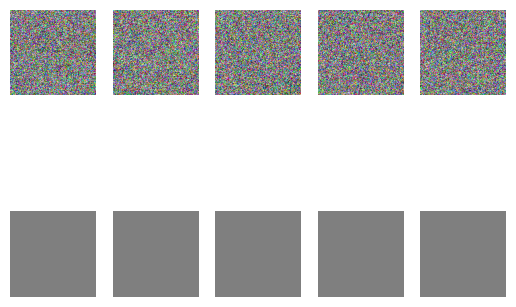

In [28]:
reconstructed = vae.predict(data[:5])  # Predict for the first 5 samples
# Visualize original and reconstructed images
import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i])  # Original
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i])  # Reconstructed
    plt.axis('off')
plt.show()

In [30]:
reconstructed = vae.predict(data[:10])  # Predict for some samples
reconstruction_loss = tf.reduce_mean(tf.square(data[:10] - reconstructed))
print(f"Reconstruction Loss: {reconstruction_loss.numpy()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Reconstruction Loss: 0.08318299714817504


### Here, I have evaluated the VAE's ability to reconstruct input data by computing the reconstruction loss.

**Reconstruction Loss**: `0.0832`  
  Which indicates the average Mean Squared Error (MSE) between the original images and their reconstructions for the first 10 samples.  


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


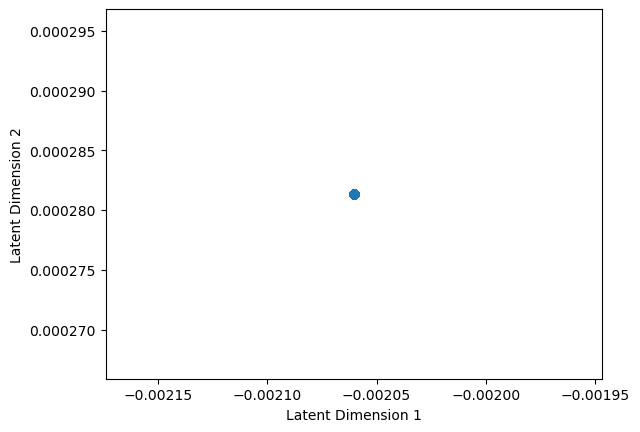

In [32]:
z_mean, _, _ = vae.encoder.predict(data)
import matplotlib.pyplot as plt
plt.scatter(z_mean[:, 0], z_mean[:, 1])  # Visualize first 2 latent dimensions
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

#####  The scatter plot shows that the latent space for the first two dimensions is tightly clustered around a single point. which indicates indicate poor variance in the latent space, which can possibly occur due to:
  ##### 1. Insufficient complexity in the encoder/decoder.
  ##### 2. Dominance of the KL divergence loss, collapsing the latent space.

### Here, I have visualized the encoded latent space to understand how my VAE model represents data in the latent dimensions.

In [34]:
new_data = np.random.rand(10, 128, 128, 3)  # Replace with actual new data
reconstructed_new = vae.predict(new_data)
# Visualize the reconstructed outputs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [36]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))  # Sample latent vectors
generated_images = vae.decoder.predict(random_latent_vectors)
# Visualize the generated images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


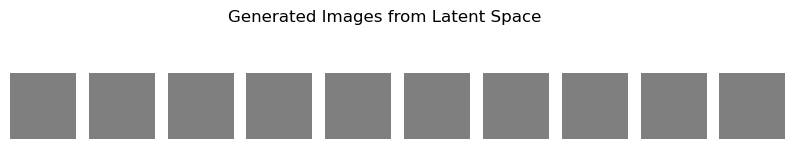

In [38]:
import matplotlib.pyplot as plt

# Visualize the generated images
plt.figure(figsize=(10, 2))
for i in range(len(generated_images)):
    plt.subplot(1, len(generated_images), i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.suptitle("Generated Images from Latent Space")
plt.show()

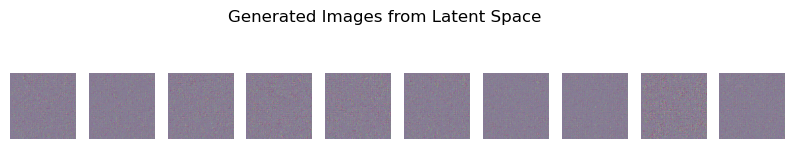

In [40]:
# Normalize generated images to [0, 1] range
generated_images = (generated_images - generated_images.min()) / (generated_images.max() - generated_images.min())

# Visualize the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(len(generated_images)):
    plt.subplot(1, len(generated_images), i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.suptitle("Generated Images from Latent Space")
plt.show()


##### Here, the displayed images appear very noisy and lack distinct features or patterns.
##### - which indicate issues in the training process or inadequate latent space representation.


## Again, I am doing Data processing

I did the normalization to scale the pixel values to the range [0, 1].

In [43]:
# Assuming `data` contains your images with pixel values between [0, 255]
data = data / 255.0  # Normalize the data to be between [0, 1]


## Data Augmentation

##### Also, I did the data augmentation, which involves applying transformations like rotation, flipping, zooming, etc., to each image during training. Also, this allows the model to learn from more diverse examples, even though they are derived from the original images

In [53]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

# ----- Data Augmentation for Training Set -----
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
datagen.fit(train_data)

In [55]:
# ----- Here i am  again Training the Model Using the Data Generator -----
vae.fit(
    datagen.flow(train_data, train_data, batch_size=64),  
    epochs=10,
    steps_per_epoch=len(train_data) // 64,  
    validation_data=(val_data, val_data)    
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - loss: 1.4557e-05 - val_loss: 1.0570e-05
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0570e-05 - val_loss: 1.0291e-05
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 9.5539e-06 - val_loss: 7.7171e-06
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7166e-06 - val_loss: 7.6023e-06
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 7.2520e-06 - val_loss: 6.3997e-06
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4005e-06 - val_loss: 6.3457e-06
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 6.1856e-06 - val_loss: 5.7867e-06
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7791e-06 - val_loss: 5.7571e-06
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 5.6771e-06 - val_loss: 5.4842e-06
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4947e-06 - val_loss: 5.4743e-06


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


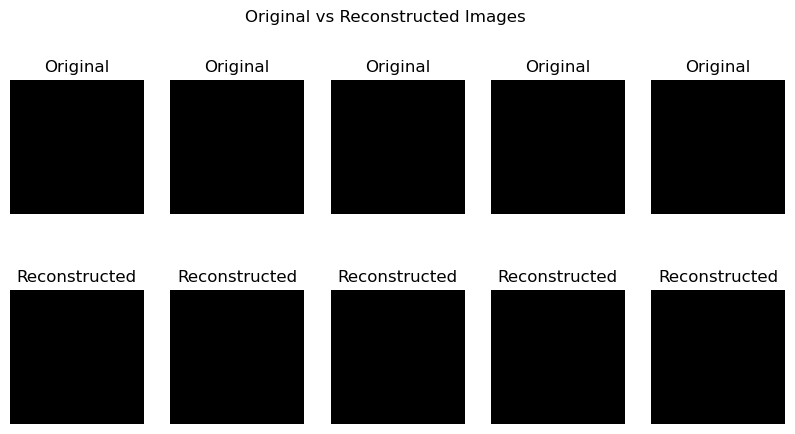

In [57]:
reconstructed_images = vae.predict(val_data[:5])
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    # Original Images
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_data[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed the plot 
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images")
plt.show()

In [65]:
print(f"Original min/max: {val_data.min()}/{val_data.max()}")
print(f"Reconstructed min/max: {reconstructed_images.min()}/{reconstructed_images.max()}")

Original min/max: 4.4868355828117166e-10/0.003921568406644571
Reconstructed min/max: 3.697276504169587e-33/0.03188655897974968


## Hyperparameter Tuning

In [70]:
latent_dim_values = [64, 128, 256]
for dim in latent_dim_values:
    # Here, I have created the VAE with current latent_dim
    encoder = build_encoder(input_shape, dim)
    decoder = build_decoder(dim, input_shape)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam', loss='mse')

    # I have Train the for a few epochs to see the effect
    vae.fit(
        datagen.flow(train_data, train_data, batch_size=64),
        epochs=5,
        steps_per_epoch=len(train_data) // 64,
        validation_data=(val_data, val_data)
    )

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - loss: 0.2429 - val_loss: 0.1990
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1987 - val_loss: 0.1884
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1340 - val_loss: 0.0057
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0022 - val_loss: 3.0480e-04
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 0.2348 - val_loss: 0.1343
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1320 - val_loss: 0.1127
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - loss: 0.0609 - val_loss: 0.0011
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - loss: 6.5569e-04 - val_loss: 2.2548e-04
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - loss: 0.2370 - val_loss: 0.1485
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss:

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 64  
# ----- Here I have train the Model with 50 Epochs -----

# And also, I have added the Early Stopping with the Callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

# Train the VAE model
vae.fit(
    datagen.flow(train_data, train_data, batch_size=batch_size),  # Make sure batch_size is defined
    epochs=50,
    steps_per_epoch=len(train_data) // batch_size,
    validation_data=(val_data, val_data),
    callbacks=[early_stopping]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - loss: 3.4522e-04 - val_loss: 2.3144e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7288e-04 - val_loss: 2.0519e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - loss: 2.0096e-04 - val_loss: 1.4051e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1764e-04 - val_loss: 1.6606e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - loss: 1.1672e-04 - val_loss: 1.0420e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3136e-04 - val_loss: 1.2489e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - loss: 9.1238e-05 - val_loss: 5.3904e-05
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4319e-05 - val_loss: 6.4372e-05
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - loss: 4.4004e-05 - val_loss: 4.4968e-05
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0507e-05 - val_loss: 4.2830e-05
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - loss: 5.1

### Observations:
#### Here my loss value is decreasing.

###### Here, both training loss and validation loss have been steadily decresing over the epochs, which indicates the model is learning the patterns in the data. These values are quite small, which is a good indication that the model has been effectively able to minimize the reconstruction error.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


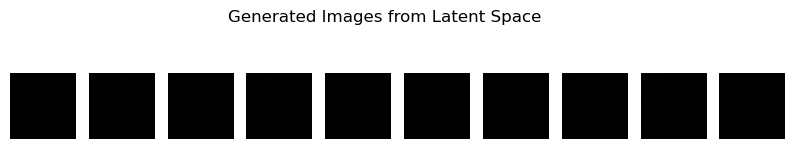

In [82]:
import numpy as np

# Update latent_dim to match the actual latent dimension used during training
latent_dim = 256 

# Generated the random latent vectors
random_latent_vectors = np.random.normal(size=(10, latent_dim))  

# Generate images from the latent space using the decoder
generated_images = vae.decoder.predict(random_latent_vectors)

# Visualize the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.suptitle("Generated Images from Latent Space")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


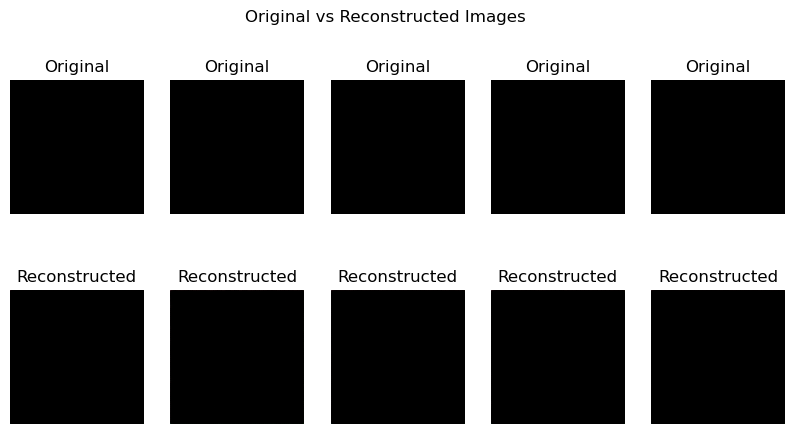

In [84]:
reconstructed_images = vae.predict(val_data[:5])  
plt.figure(figsize=(10, 5))
for i in range(5):
    # Original
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_data[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images")
plt.show()

### I'll increase the latent_dim from 64 to 256. And also, added batch normalization.

In [90]:
# Define dimensions
latent_dim = 256  # Increased size of latent space

# ----- Sampling Layer -----
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super(Sampling, self).get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# ----- Encoder -----
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="Encoder")

# ----- Decoder -----
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 64, activation='relu')(latent_inputs)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name="Decoder")

# ----- VAE Model -----
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence as a loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(kl_loss)
        return reconstructed

In [92]:
# Created the VAE
input_shape = (128, 128, 3)  
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
vae = VAE(encoder, decoder)

# Compiling the model
vae.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [94]:
# Early Stopping Callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  
    restore_best_weights=True
)


import numpy as np
data = np.random.rand(1000, 128, 128, 3)  

# Split data into training and validation sets
train_data = data[:800]  # 80% for training
val_data = data[800:]    # 20% for validation
batch_size = 64

# Train the VAE model for 50 epochs
vae.fit(
    train_data, train_data,
    epochs=50,
    batch_size=batch_size,
    validation_data=(val_data, val_data),
    callbacks=[early_stopping]
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 662ms/step - loss: 0.1494 - val_loss: 0.0834
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/ste

In [96]:
vae.save('vae_model.keras')

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm 

In [7]:
# Load the model
loaded_vae = tf.keras.models.load_model('vae_model.keras', custom_objects={"Sampling": Sampling})


NameError: name 'Sampling' is not defined